### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Importing main libraries used

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import PIL
import pandas as pd

classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

In [3]:
def myClassType(myClass):
    return_class = []
    for i in myClass:
        if (i == 0):
            return_class += ['anger']
        if (i == 1):
            return_class += ['disgust']
        if (i == 2):
            return_class += ['fear']
        if (i == 3):
            return_class += ['happy']
        if (i == 4):
            return_class += ['sadness']
        if (i == 5):
            return_class += ['surprise']
    return return_class

### Sample image from each class

S102_009_00000013-10.2.png
S058_005_000000084.8.png
S072_006_00000021-4.2.png
S011_002_000000208.7.png
S055_006_00000005-4.2.png
S063_001_00000012-6.0.png


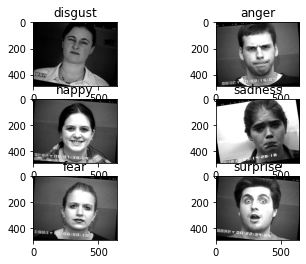

In [4]:
path = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+_Complete'

for index, directory_name in enumerate(os.listdir(path)):
    joined_directory = os.path.join(path, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(3, 2, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

### Printing of dataframe to show matching labels

In [5]:

#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'sad' in str(file_name):
        return 4
    if 'surprise' in str(file_name):
        return 5


categories = []

filenames = get_all_file_paths(path)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


<AxesSubplot: >

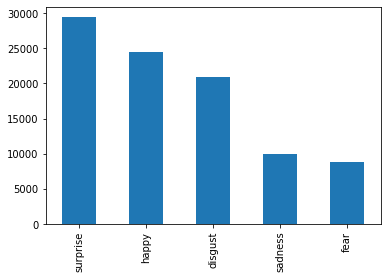

In [6]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Training and Testing Models

Code implementation for each modes is the same throughout the experiment.
<br>Thus, only the first model contains information and comments about the implmentation.
<br>Simply need to change the variables 'path', 'MODEL_NAME' for each models
<br>
<br>To avoid overfitting, early-stopping feature is implemented to stop the training 

## ====No Pre-Processing=====

Training the basic model with Dataset1 
Testing with basic test set 1

In [7]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CK_s1'
dataset_2_folder_name = 'CK_s2'
dataset_3_folder_name = 'CK_s3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

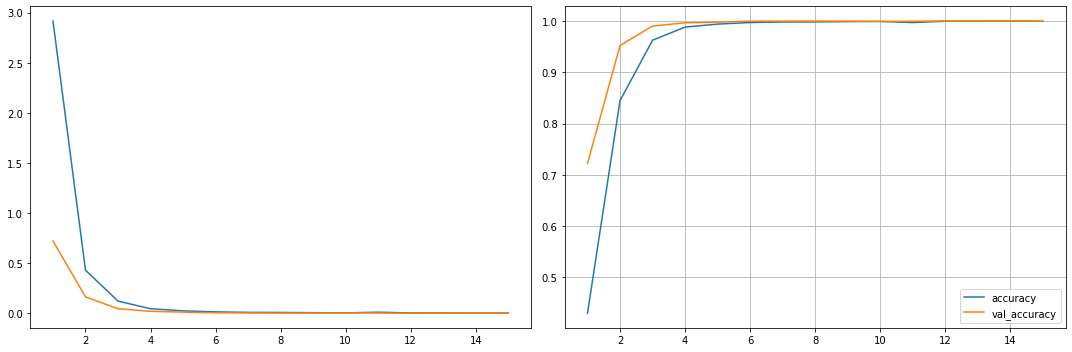

142/142 [==============================] - 45s 307ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9997


In [8]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 102s 2s/step
              precision    recall  f1-score   support

       anger       0.20      0.18      0.19      3195
     disgust       0.38      0.32      0.35      4260
        fear       0.11      0.15      0.12      1775
       happy       0.84      0.58      0.69      4970
     sadness       0.12      0.31      0.17      1420
    surprise       0.73      0.67      0.70      5680

    accuracy                           0.44     21300
   macro avg       0.40      0.37      0.37     21300
weighted avg       0.51      0.44      0.47     21300



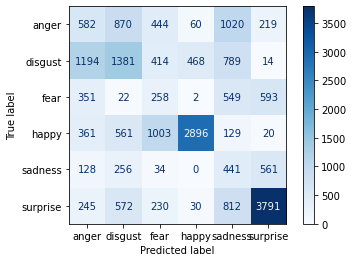

In [9]:
# WEIGHT_NAME = "1_basic_d1.h5"

test_dir = os.path.join(project_folder_name, folder_type[1])
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset2

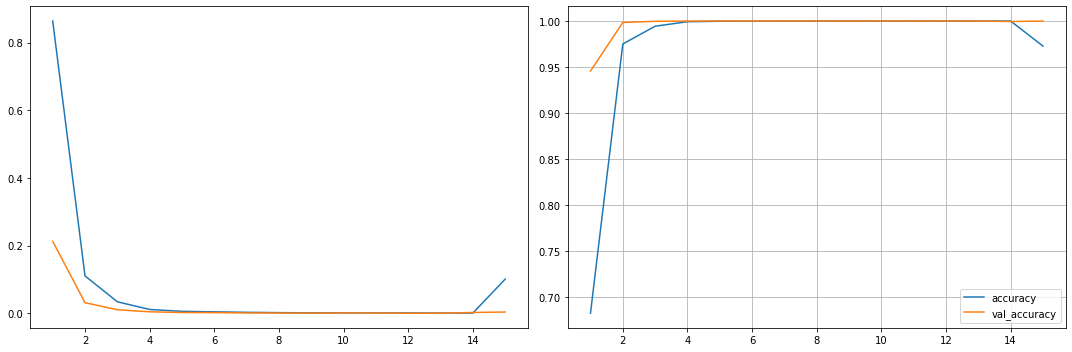

141/141 [==============================] - 47s 321ms/step - loss: 0.1008 - accuracy: 0.9728 - val_loss: 0.0036 - val_accuracy: 0.9999


In [10]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.24      0.59      0.34      3195
     disgust       0.50      0.32      0.39      4260
        fear       0.19      0.26      0.22      1775
       happy       0.80      0.47      0.59      4970
     sadness       0.03      0.01      0.01      1775
    surprise       0.62      0.56      0.59      5680

    accuracy                           0.43     21655
   macro avg       0.40      0.37      0.36     21655
weighted avg       0.50      0.43      0.44     21655



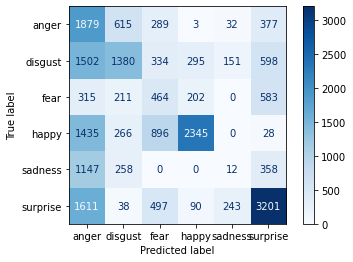

In [11]:
# WEIGHT_NAME = '1_basic_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

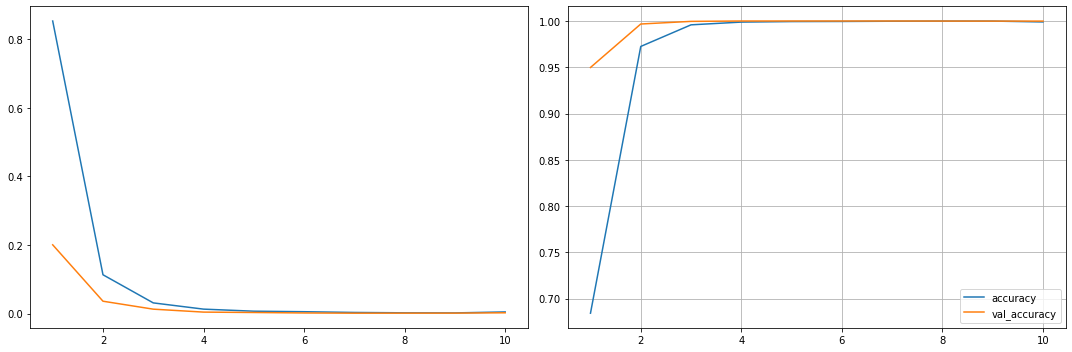

141/141 [==============================] - 46s 315ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0021 - val_accuracy: 0.9999


In [12]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 99s 2s/step
              precision    recall  f1-score   support

       anger       0.52      0.11      0.18      3195
     disgust       0.44      0.70      0.54      4260
        fear       0.00      0.00      0.00      1775
       happy       0.72      0.72      0.72      4970
     sadness       0.49      0.51      0.50      1775
    surprise       0.72      0.88      0.79      5680

    accuracy                           0.59     21655
   macro avg       0.48      0.49      0.46     21655
weighted avg       0.56      0.59      0.55     21655



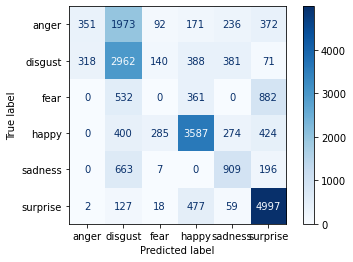

In [13]:
# WEIGHT_NAME = '1_basic_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### ====Image Cropping====

Training and Testing on the image cropping model with Dataset1

In [14]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Cropping_1'
dataset_2_folder_name = 'CKD_Cropping_2'
dataset_3_folder_name = 'CKD_Cropping_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

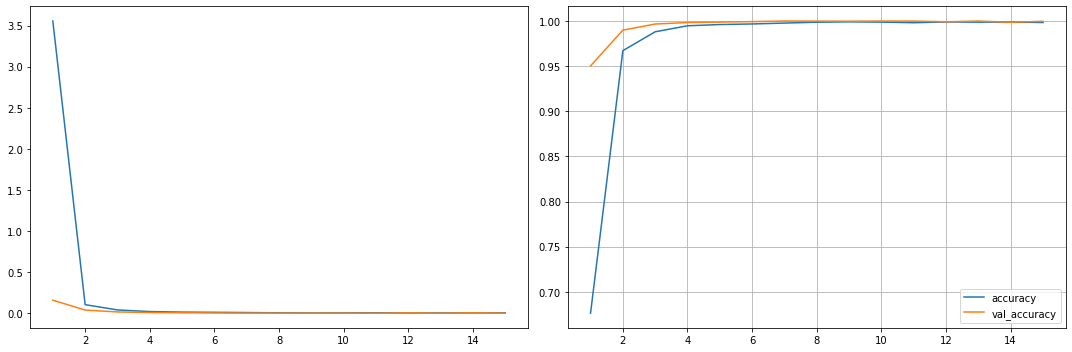

142/142 [==============================] - 16s 108ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0014 - val_accuracy: 0.9995


In [15]:


path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 107s 2s/step
              precision    recall  f1-score   support

       anger       0.52      0.29      0.37      3195
     disgust       0.14      0.10      0.12      4260
        fear       0.00      0.00      0.00      1775
       happy       0.35      0.14      0.20      4970
     sadness       0.18      0.15      0.16      1420
    surprise       0.36      0.83      0.50      5680

    accuracy                           0.33     21300
   macro avg       0.26      0.25      0.22     21300
weighted avg       0.30      0.33      0.27     21300



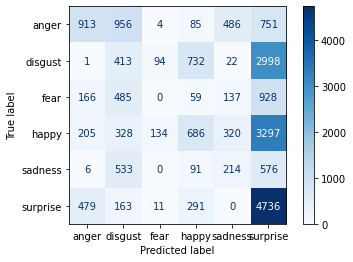

In [16]:
# WEIGHT_NAME = '1_crop_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the image cropping model with Dataset2

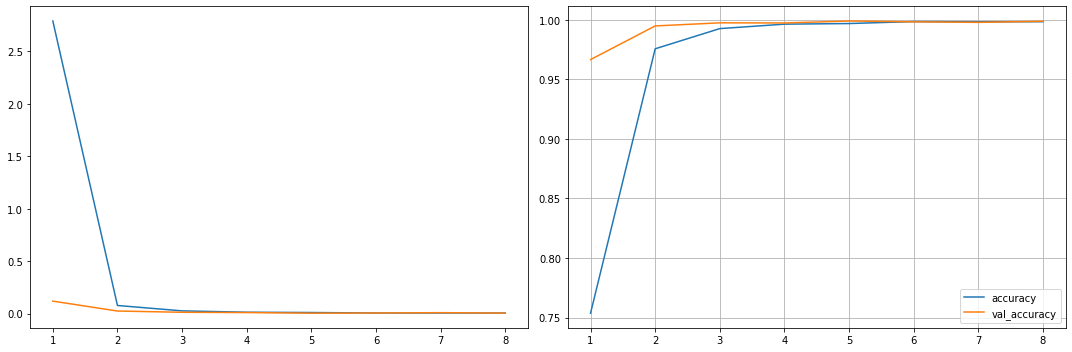

141/141 [==============================] - 15s 106ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0053 - val_accuracy: 0.9988


In [17]:

path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.12      0.07      0.09      3195
     disgust       0.12      0.04      0.06      4260
        fear       0.04      0.05      0.04      1775
       happy       0.24      0.24      0.24      4970
     sadness       0.30      0.17      0.21      1775
    surprise       0.25      0.45      0.32      5680

    accuracy                           0.21     21655
   macro avg       0.18      0.17      0.16     21655
weighted avg       0.19      0.21      0.18     21655



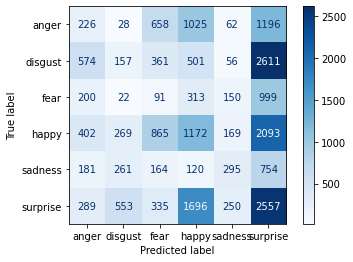

In [18]:
# WEIGHT_NAME = '1_crop_d2.h5'

#Fetch testing data from the dataset2
test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

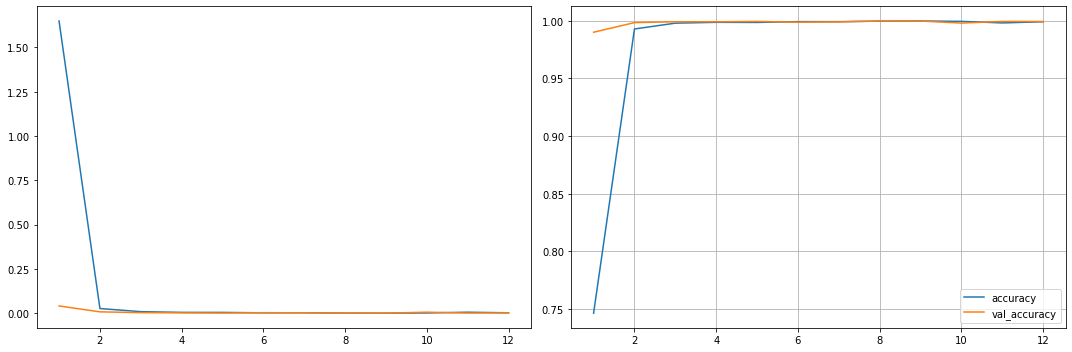

141/141 [==============================] - 16s 110ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0024 - val_accuracy: 0.9994


In [19]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 100s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.05      0.01      0.01      4260
        fear       0.01      0.01      0.01      1775
       happy       0.42      0.11      0.17      4970
     sadness       0.09      0.13      0.11      1775
    surprise       0.25      0.69      0.36      5680

    accuracy                           0.22     21655
   macro avg       0.14      0.16      0.11     21655
weighted avg       0.18      0.22      0.15     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


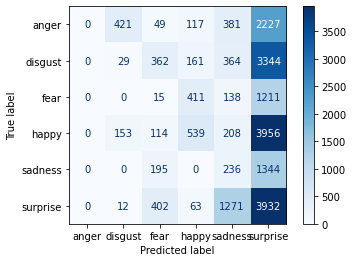

In [20]:
# WEIGHT_NAME = '1_crop_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## ====Intensity Normalization====

Training and Testing on the Intensity Normalization model with Dataset1

In [21]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_IntentNorm_1'
dataset_2_folder_name = 'CKD_IntentNorm_2'
dataset_3_folder_name = 'CKD_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

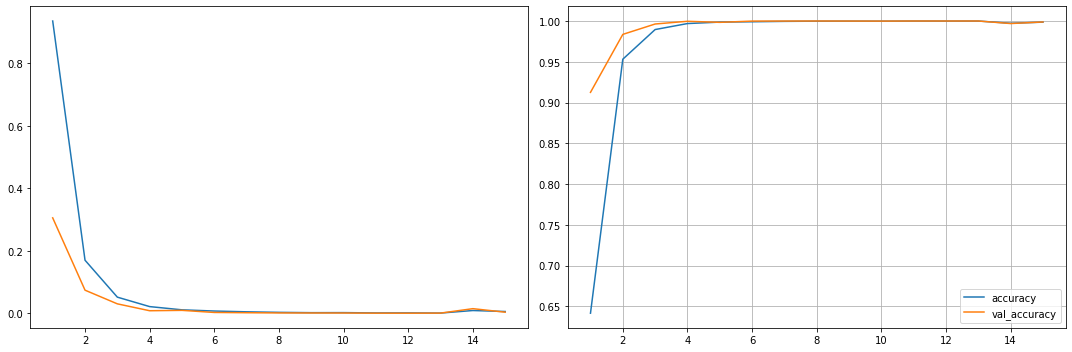

142/142 [==============================] - 16s 110ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 0.0036 - val_accuracy: 0.9988


In [22]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 101s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.19      0.21      3195
     disgust       0.21      0.25      0.23      4260
        fear       0.03      0.02      0.02      1775
       happy       0.68      0.82      0.74      4970
     sadness       0.40      0.73      0.52      1420
    surprise       0.91      0.64      0.75      5680

    accuracy                           0.49     21300
   macro avg       0.41      0.44      0.41     21300
weighted avg       0.51      0.49      0.49     21300



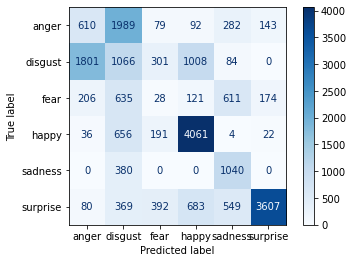

In [23]:
# WEIGHT_NAME = '1_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Intensity Normalization model with Dataset2

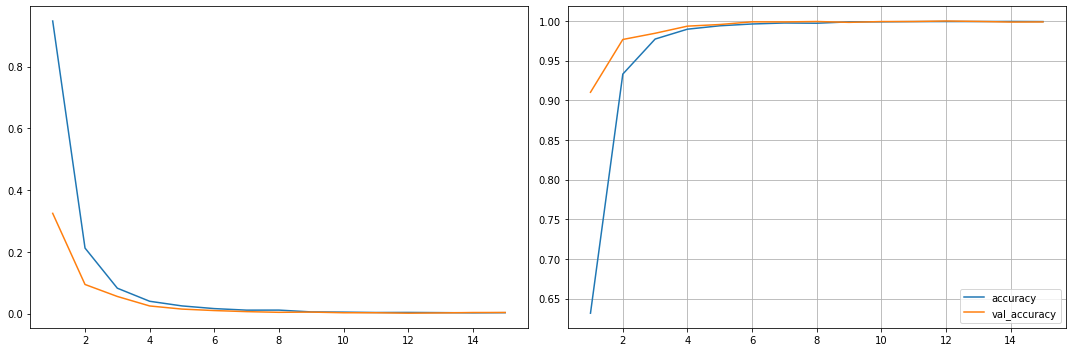

141/141 [==============================] - 16s 111ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0036 - val_accuracy: 0.9988


In [24]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 93s 2s/step
              precision    recall  f1-score   support

       anger       0.20      0.71      0.31      3195
     disgust       0.59      0.35      0.44      4260
        fear       0.07      0.04      0.05      1775
       happy       0.77      0.35      0.48      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.77      0.54      0.64      5680

    accuracy                           0.40     21655
   macro avg       0.40      0.33      0.32     21655
weighted avg       0.53      0.40      0.41     21655



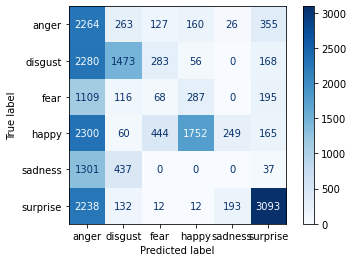

In [25]:
# WEIGHT_NAME = '1_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We are here

Training and Testing on the Intensity Normalization model with Dataset3

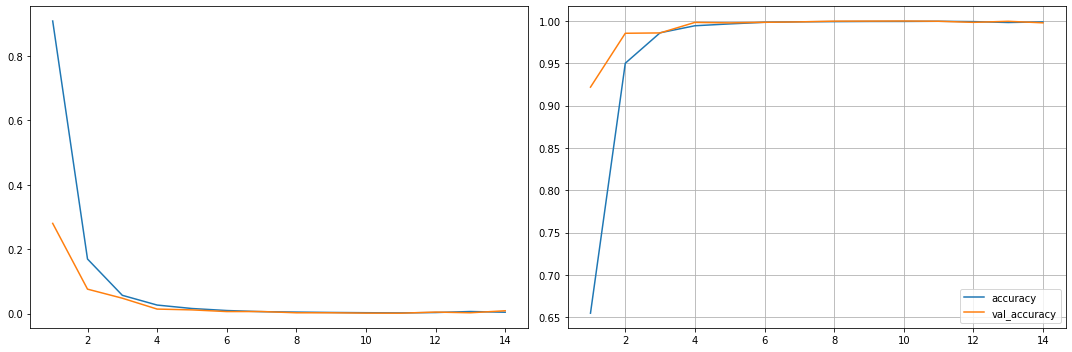

141/141 [==============================] - 16s 110ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0088 - val_accuracy: 0.9978


In [26]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 98s 2s/step
              precision    recall  f1-score   support

       anger       0.46      0.06      0.11      3195
     disgust       0.37      0.80      0.51      4260
        fear       0.00      0.00      0.00      1775
       happy       0.73      0.78      0.75      4970
     sadness       0.84      0.15      0.26      1775
    surprise       0.76      0.84      0.80      5680

    accuracy                           0.58     21655
   macro avg       0.53      0.44      0.40     21655
weighted avg       0.58      0.58      0.52     21655



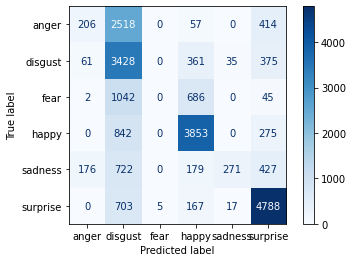

In [27]:
# WEIGHT_NAME = '1_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Image Cropping and Intensity Normalization====

Training and Testing on the Cropping and Intensity Normalization model with Dataset1

In [28]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Crop_IntentNorm_1'
dataset_2_folder_name = 'CKD_Crop_IntentNorm_2'
dataset_3_folder_name = 'CKD_Crop_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

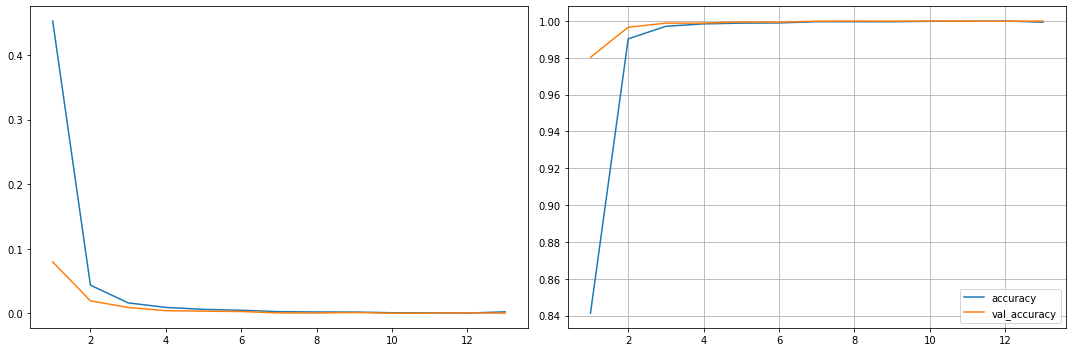

142/142 [==============================] - 10s 66ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 4.3760e-04 - val_accuracy: 0.9999


In [29]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d1.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 101s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.00      0.00      3195
     disgust       0.43      0.44      0.44      4260
        fear       0.00      0.00      0.00      1775
       happy       0.25      0.15      0.19      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.30      0.58      0.40      5680

    accuracy                           0.28     21300
   macro avg       0.17      0.20      0.17     21300
weighted avg       0.23      0.28      0.24     21300



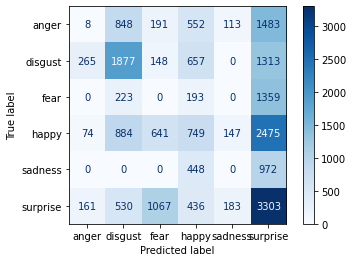

In [30]:
# WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset2

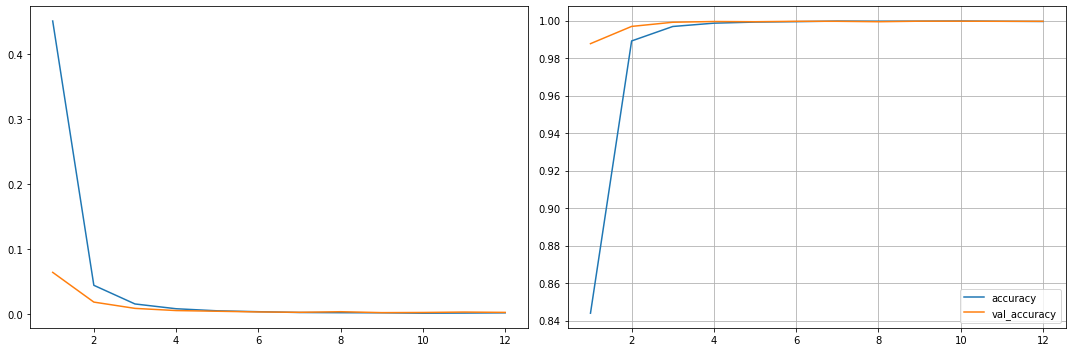

141/141 [==============================] - 10s 67ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0024 - val_accuracy: 0.9997


In [31]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d2.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 93s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.01      0.01      3195
     disgust       0.28      0.34      0.31      4260
        fear       0.03      0.08      0.05      1775
       happy       0.23      0.13      0.17      4970
     sadness       0.25      0.18      0.21      1775
    surprise       0.33      0.41      0.37      5680

    accuracy                           0.23     21655
   macro avg       0.19      0.19      0.18     21655
weighted avg       0.22      0.23      0.22     21655



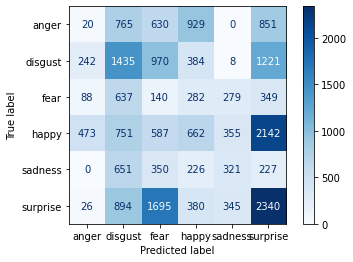

In [32]:
# WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset3


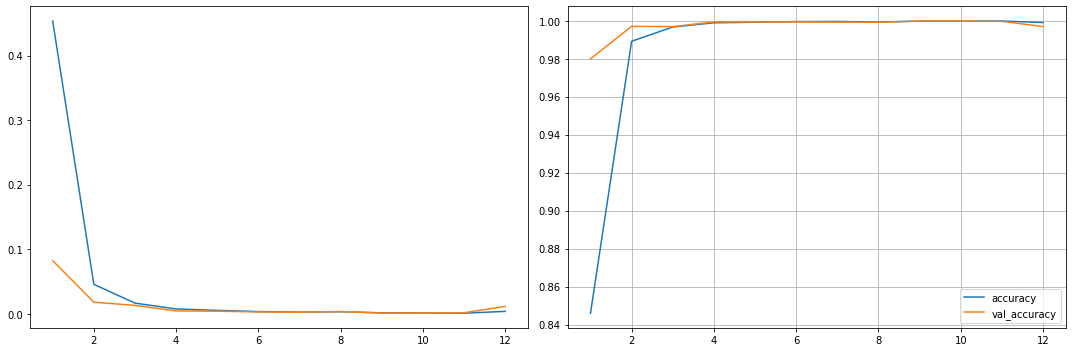

141/141 [==============================] - 10s 68ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0113 - val_accuracy: 0.9969


In [33]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_CR_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 98s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.15      0.07      0.09      4260
        fear       0.00      0.00      0.00      1775
       happy       0.29      0.47      0.36      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.28      0.53      0.37      5680

    accuracy                           0.26     21655
   macro avg       0.12      0.18      0.14     21655
weighted avg       0.17      0.26      0.20     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


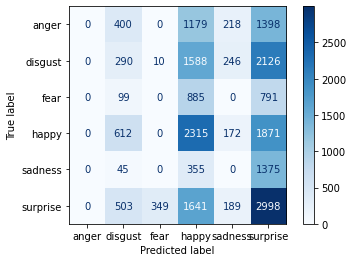

In [34]:
# WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Testing with Pre-Processed Images====


Model structure to run in order to load weights

In [4]:

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

## Testing with Normalized images


Take the model trained with no pre-processed images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 196s 5s/step
              precision    recall  f1-score   support

       anger       0.26      0.19      0.22      3195
     disgust       0.24      0.24      0.24      4260
        fear       0.01      0.01      0.01      1775
       happy       0.46      0.38      0.41      4970
     sadness       0.20      0.25      0.23      1420
    surprise       0.56      0.56      0.56      5680

    accuracy                           0.33     21300
   macro avg       0.29      0.27      0.28     21300
weighted avg       0.36      0.33      0.34     21300



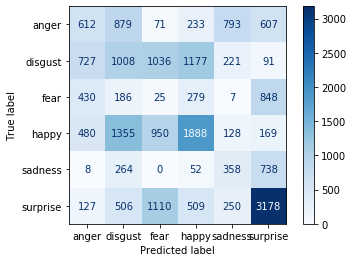

In [6]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2<br>

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 95s 2s/step
              precision    recall  f1-score   support

       anger       0.21      0.48      0.29      3195
     disgust       0.45      0.05      0.09      4260
        fear       0.14      0.48      0.21      1775
       happy       0.60      0.35      0.44      4970
     sadness       0.11      0.02      0.03      1775
    surprise       0.69      0.59      0.64      5680

    accuracy                           0.35     21655
   macro avg       0.37      0.33      0.28     21655
weighted avg       0.46      0.35      0.35     21655



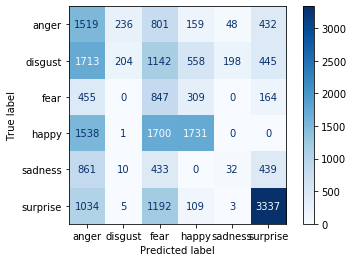

In [7]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3<br>

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 87s 2s/step
              precision    recall  f1-score   support

       anger       0.15      0.02      0.03      3195
     disgust       0.29      0.07      0.12      4260
        fear       0.09      0.21      0.13      1775
       happy       0.29      0.63      0.40      4970
     sadness       0.54      0.30      0.38      1775
    surprise       0.74      0.59      0.66      5680

    accuracy                           0.36     21655
   macro avg       0.35      0.30      0.29     21655
weighted avg       0.39      0.36      0.33     21655



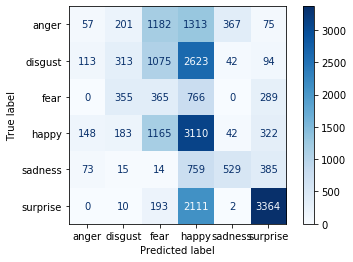

In [8]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 2385s 57s/step
              precision    recall  f1-score   support

       anger       0.17      0.00      0.00      3195
     disgust       0.07      0.06      0.07      4260
        fear       0.00      0.00      0.00      1775
       happy       0.31      0.27      0.29      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.38      0.88      0.53      5680

    accuracy                           0.31     21300
   macro avg       0.16      0.20      0.15     21300
weighted avg       0.21      0.31      0.22     21300



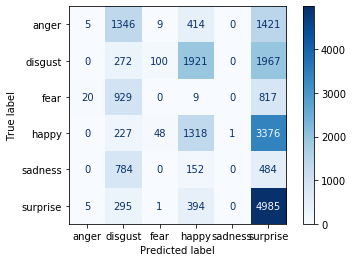

In [9]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 6357s 148s/step
              precision    recall  f1-score   support

       anger       0.15      0.10      0.12      3195
     disgust       0.30      0.08      0.13      4260
        fear       0.02      0.02      0.02      1775
       happy       0.27      0.25      0.26      4970
     sadness       0.53      0.07      0.12      1775
    surprise       0.25      0.54      0.35      5680

    accuracy                           0.24     21655
   macro avg       0.25      0.18      0.17     21655
weighted avg       0.25      0.24      0.21     21655



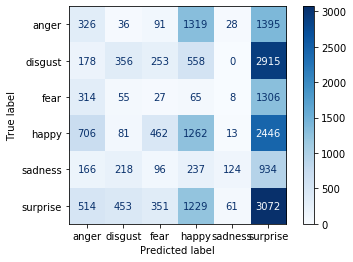

In [10]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.08      0.00      0.01      3195
     disgust       0.54      0.02      0.05      4260
        fear       0.01      0.00      0.00      1775
       happy       0.27      0.21      0.23      4970
     sadness       0.28      0.10      0.15      1775
    surprise       0.28      0.80      0.41      5680

    accuracy                           0.27     21655
   macro avg       0.24      0.19      0.14     21655
weighted avg       0.27      0.27      0.18     21655



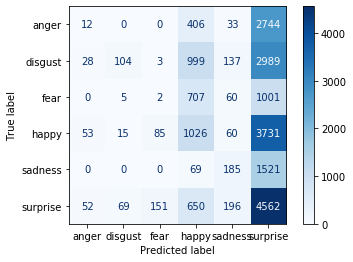

In [11]:
EIGHT_NAME = '1_crop_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 82s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.21      0.22      3195
     disgust       0.18      0.11      0.14      4260
        fear       0.02      0.02      0.02      1775
       happy       0.67      0.47      0.55      4970
     sadness       0.17      0.57      0.26      1420
    surprise       0.79      0.72      0.76      5680

    accuracy                           0.40     21300
   macro avg       0.34      0.35      0.32     21300
weighted avg       0.45      0.40      0.41     21300



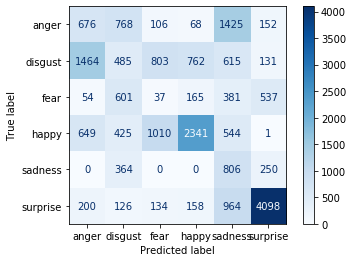

In [12]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 96s 2s/step
              precision    recall  f1-score   support

       anger       0.23      0.82      0.36      3195
     disgust       0.41      0.18      0.25      4260
        fear       0.16      0.20      0.18      1775
       happy       0.63      0.20      0.30      4970
     sadness       0.13      0.00      0.01      1775
    surprise       0.63      0.52      0.57      5680

    accuracy                           0.35     21655
   macro avg       0.37      0.32      0.28     21655
weighted avg       0.45      0.35      0.34     21655



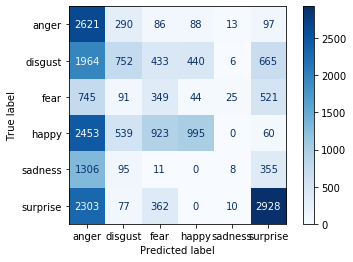

In [13]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 91s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.04      0.06      3195
     disgust       0.25      0.49      0.34      4260
        fear       0.44      0.06      0.10      1775
       happy       0.42      0.52      0.46      4970
     sadness       0.51      0.18      0.26      1775
    surprise       0.72      0.75      0.73      5680

    accuracy                           0.43     21655
   macro avg       0.42      0.34      0.33     21655
weighted avg       0.44      0.43      0.40     21655



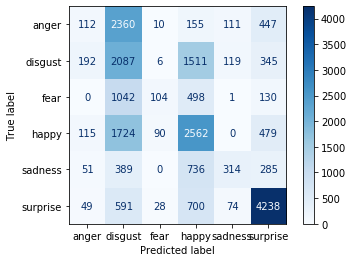

In [14]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 83s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.01      0.01      3195
     disgust       0.34      0.45      0.39      4260
        fear       0.00      0.00      0.00      1775
       happy       0.33      0.24      0.28      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.31      0.54      0.39      5680

    accuracy                           0.29     21300
   macro avg       0.17      0.21      0.18     21300
weighted avg       0.23      0.29      0.25     21300



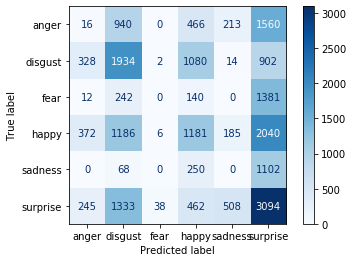

In [15]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 92s 2s/step
              precision    recall  f1-score   support

       anger       0.13      0.10      0.11      3195
     disgust       0.20      0.30      0.24      4260
        fear       0.01      0.01      0.01      1775
       happy       0.23      0.06      0.09      4970
     sadness       0.24      0.21      0.23      1775
    surprise       0.28      0.42      0.33      5680

    accuracy                           0.21     21655
   macro avg       0.18      0.18      0.17     21655
weighted avg       0.21      0.21      0.19     21655



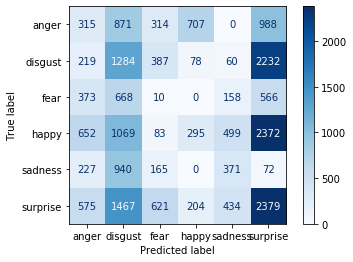

In [16]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 92s 2s/step


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.23      0.06      0.10      4260
        fear       0.00      0.00      0.00      1775
       happy       0.31      0.48      0.38      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.32      0.65      0.43      5680

    accuracy                           0.29     21655
   macro avg       0.14      0.20      0.15     21655
weighted avg       0.20      0.29      0.22     21655



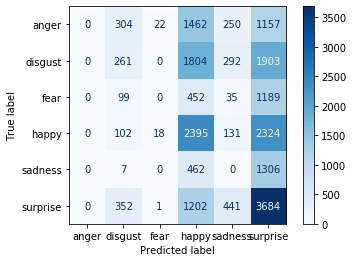

In [17]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# START RUNNING FROM HERE

## Testing with cropped images


Take the model trained with no pre-processing<br>
Test with cropped images<br><br>
Dataset 1

In [ ]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped image<br>
Test with cropped images<br><br>
Dataset 1

In [ ]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_crop_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with cropped images<br><br>
Dataset 1

In [ ]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with cropped images<br><br>
Dataset 1

In [ ]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Testing with Cropped and Normalized images


Take the model trained with no pre-processed images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

In [ ]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

In [ ]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_crop_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

In [ ]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

In [ ]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

In [ ]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

In [ ]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = 'DIRECTORY NAME'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()